Sajad Rahmanian 97101683

# Acknoledment
I used [this post](https://medium.com/analytics-vidhya/use-pytorch-to-create-an-image-captioning-model-with-cnn-and-seq2seq-lstm-and-train-on-google-e6563cb9f511) for some parts of my implementation and for the whloe view

# Download data

In [1]:
!gdown http://images.cocodataset.org/zips/train2014.zip

Downloading...
From: http://images.cocodataset.org/zips/train2014.zip
To: /content/train2014.zip
100% 13.5G/13.5G [10:38<00:00, 21.2MB/s]


In [2]:
!gdown http://images.cocodataset.org/zips/val2014.zip
!gdown http://images.cocodataset.org/annotations/annotations_trainval2014.zip

Downloading...
From: http://images.cocodataset.org/zips/val2014.zip
To: /content/val2014.zip
100% 6.65G/6.65G [07:26<00:00, 14.9MB/s]
Downloading...
From: http://images.cocodataset.org/annotations/annotations_trainval2014.zip
To: /content/annotations_trainval2014.zip
100% 253M/253M [00:04<00:00, 53.2MB/s]


In [3]:
!unzip -q '/content/annotations_trainval2014.zip' -d './data'
!unzip -q '/content/train2014.zip' -d './data'
!unzip -q '/content/val2014.zip' -d './data'

In [4]:
!rm '/content/train2014.zip'
!rm '/content/val2014.zip'
!rm '/content/annotations_trainval2014.zip'

# Import necessary packages

In [128]:
from pycocotools.coco import COCO
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import torch
from torchvision.transforms import transforms
from PIL import Image
import numpy as np
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [129]:
START_WORD = "aghaz"
END_WORD = "payan"
UNKNOWN_WORD = "mobham"

# Tokenizer for omitting invalid words

In [130]:
def my_tokenizer(text):
    text_lower = text.lower()
    def contains_numbers(word):
        for char in word:
            if char.isdigit():
                return True
        return False
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text_lower)
    tokens_final = []
    for token in tokens:
        if not contains_numbers(token):
            tokens_final.append(token)
    return tokens_final

In [131]:
my_tokenizer("This is a sample cas3 !!?")

['this', 'is', 'a', 'sample']

# Create vocab dictionary

In [41]:
def create_vocab(path='/content/data/annotations/captions_train2014.json'):
    

    word_to_idx = {START_WORD: 0, END_WORD: 1, UNKNOWN_WORD: 2}
    idx_to_word = {v: k for k, v in word_to_idx.items()}
    current_idx = 3
    coco_cap = COCO(path)
    ids = coco_cap.anns.keys()
    words = []
    for id in tqdm(ids):
        cap = str(coco_cap.anns[id]["caption"])
        tokens = my_tokenizer(cap)
        for word in tokens:
            if word not in words:
                words.append(word)
                word_to_idx[word] = current_idx
                idx_to_word[current_idx] = word
                current_idx += 1
    return word_to_idx, idx_to_word, current_idx

In [42]:
word_to_idx, idx_to_word, vocab_len = create_vocab()

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


100%|██████████| 414113/414113 [00:39<00:00, 10398.61it/s]


In [43]:
import pickle

with open("./word_to_idx.pkl", 'wb') as f:
    pickle.dump(word_to_idx, f)
with open("./idx_to_word.pkl", 'wb') as f:
    pickle.dump(idx_to_word, f)

# Create dataset

In [132]:
from torch.utils.data import Dataset
class CustomDataSet(Dataset):
    def __init__(self,
                 max_cap_len,
                 w2i=word_to_idx,
                 anns_file="/content/data/annotations/captions_train2014.json",
                 img_folder="/content/data/train2014",
                 transform=None):
        self.max_cap_len = max_cap_len
        self.w2i = w2i
        self.img_folder = img_folder
        self.transform = transform
        self.anns_file = anns_file
        self.coco = COCO(self.anns_file)
        self.ids = list(self.coco.anns.keys())
        self.all_tokens = [my_tokenizer(str(self.coco.anns[id]["caption"])) for id in self.ids]

    def word_to_idx_map(self, token):
        if token in self.w2i.keys():
            return self.w2i[token]
        else:
            return self.w2i[UNKNOWN_WORD]

    def __getitem__(self, index):

        tokens = self.all_tokens[index]
        tokens_trans = [self.word_to_idx_map(START_WORD)]
        tokens_trans += [self.word_to_idx_map(token) for token in tokens]
        tokens_trans += [self.word_to_idx_map(END_WORD)]
        cap_len = len(tokens_trans) 
        if  cap_len < self.max_cap_len:
            for _ in range(self.max_cap_len - cap_len):
                tokens_trans.append(self.word_to_idx_map(UNKNOWN_WORD))
        tokens_out = torch.Tensor(tokens_trans).long()
        
        img_id = self.coco.anns[self.ids[index]]["image_id"]
        path = self.coco.loadImgs(img_id)[0]["file_name"]

        img = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        
        return img, tokens_out
    
    def __len__(self):
        return len(self.ids)

# Image transformer

In [133]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [46]:
def get_max_cap_len(path='/content/data/annotations/captions_train2014.json'):
    max_len = 0
    coco_cap = COCO(path)
    ids = coco_cap.anns.keys()
    for id in tqdm(ids):
        cap = str(coco_cap.anns[id]["caption"])
        tokens = my_tokenizer(cap)
        if len(tokens) > max_len:
            max_len = len(tokens)
    return max_len

In [47]:
train_cap_path = '/content/data/annotations/captions_train2014.json'
val_cap_path = '/content/data/annotations/captions_val2014.json'
max_cap_len = max(get_max_cap_len(train_cap_path), get_max_cap_len(val_cap_path)) + 2 # for start and end words

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


100%|██████████| 414113/414113 [00:03<00:00, 108594.22it/s]


loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


100%|██████████| 202654/202654 [00:01<00:00, 107991.72it/s]


In [134]:
train_data = CustomDataSet(max_cap_len,
                           w2i=word_to_idx,
                           anns_file=train_cap_path,
                           img_folder="/content/data/train2014",
                           transform=data_transform)

loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


In [49]:
len(train_data)

414113

In [135]:
val_data = CustomDataSet(max_cap_len,
                         w2i=word_to_idx,
                         anns_file=val_cap_path,
                         img_folder="/content/data/val2014",
                         transform=data_transform)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [51]:
EMBEDDING_DIM = 256

# Using ResNet50 as feature extractor

In [52]:
from torchvision.models import resnet50
from torch.nn import Linear, BatchNorm1d, Embedding, LSTM
import torch.nn as nn

In [53]:
resnet = resnet50(weights="DEFAULT")
for param in resnet.parameters():
    param.requires_grad = False

in_shape = resnet.fc.in_features
resnet.fc = Linear(in_shape, EMBEDDING_DIM)

In [54]:
class CNN_BACKBONE(nn.Module):
    def __init__(self, resnet_model=resnet):
        super(CNN_BACKBONE, self).__init__()
        self.resnet_model = resnet_model
        self.bn = BatchNorm1d(EMBEDDING_DIM)
    
    def forward(self, x):
        return self.bn(self.resnet_model(x))

In [55]:
cnn_backbone = CNN_BACKBONE(resnet)

# Language model

In [94]:
class CAPTION_GEN(nn.Module):
    def __init__(self, 
                 embedding_dim=EMBEDDING_DIM,
                 vocab_size=len(list(word_to_idx.keys())),
                 rnn_units=512):
        super(CAPTION_GEN, self).__init__()
        self.embedder = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(embedding_dim, rnn_units, 1, batch_first=True)
        self.classifier = Linear(rnn_units, vocab_size)
    
    def forward(self, features, captions):
        y = self.embedder(captions)
        y = torch.concat((features.unsqueeze(1), y), axis=1)
        y, _ = self.lstm(y)
        return self.classifier(y)

In [57]:
caption_generator = CAPTION_GEN()

In [58]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_data = DataLoader(val_data, batch_size=16, shuffle=True)

In [62]:
# Checking untrained nets
for data in train_loader:
    imgs, captions = data[0], data[1]
    features = cnn_backbone(imgs)
    probs = caption_generator(features, captions[:, :-1])
    break

In [63]:
print(f"img batch size: {imgs.shape}")
print(f"unembedded captions batch size {captions.shape}")
print(f"features batch size {features.shape}")
print(f"probs batch size {probs.shape}")

img batch size: torch.Size([16, 3, 224, 224])
unembedded captions batch size torch.Size([16, 52])
features batch size torch.Size([16, 256])
probs batch size torch.Size([16, 52, 22816])


In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [66]:
for name, param in cnn_backbone.named_parameters():
    if param.requires_grad:
        print(name)

resnet_model.fc.weight
resnet_model.fc.bias
bn.weight
bn.bias


# End to End model

In [67]:
class MyModel(nn.Module):
    def __init__(self, 
                 language_model,
                 feature_model,
                 vocab_size=len(list(word_to_idx.keys())),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer="ADAM",
                 lr=1e-3):
        
        super(MyModel, self).__init__()
        self.criterion = criterion
        self.language_model = language_model
        self.feature_model = feature_model
        self.vocab_size = vocab_size

        feature_model_params = []
        feature_model_params.append(self.feature_model.resnet_model.fc.weight)
        feature_model_params.append(self.feature_model.resnet_model.fc.bias)
        feature_model_params.append(self.feature_model.bn.weight)
        feature_model_params.append(self.feature_model.bn.bias)
        
        params = self.language_model.parameters()
        params = list(params) + feature_model_params

        if optimizer == "ADAM":
            self.optimizer = torch.optim.Adam(params, lr=lr)
        elif optimizer == "SGD":
            self.optimizer = torch.optim.SGD(params, lr=lr)
        else:
            raise NotImplementedError

    def forward(self, imgs, captions):
        features = self.feature_model(imgs)
        return self.language_model(features, captions[:, :-1])

    @staticmethod
    def calculate_accuracy(outputs, true_labels):
        predicted = torch.argmax(outputs, dim=-1)
        accuracy = torch.sum(predicted == true_labels) / true_labels.shape[0]
        return accuracy.item()

    def evaluate(self, evaluation_data, batch_size):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data,
                                       batch_size=batch_size,
                                       shuffle=True)
        loss = 0
        accuracy = 0
        for batch in evaluation_loader:
            with torch.no_grad():
                
                imgs, captions = batch[0].to(device), batch[1].to(device)
                output = self.forward(imgs, captions)
                loss += self.criterion(output.view((-1, self.vocab_size)), captions.view(-1)).cpu().item() * imgs.shape[0]
                accuracy += self.calculate_accuracy(output.view((-1, self.vocab_size)), captions.view(-1)) * imgs.shape[0]

        accuracy /= len(evaluation_data)
        loss /= len(evaluation_data)
        return accuracy, loss

    def fit(self, train_data, val_data, batch_size=64, n_epoch=12):

        train_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True)

        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []

        self.train()
        for epoch in range(n_epoch):
            print(f"Epoch #{epoch}:")
            for batch in tqdm(train_loader):
                
                imgs, captions = batch[0].to(device), batch[1].to(device)
                output = self.forward(imgs, captions)
                self.optimizer.zero_grad()
                loss = self.criterion(output.view((-1, self.vocab_size)), captions.view(-1))
                loss.backward()
                self.optimizer.step()

            train_acc_epoch, train_loss_epoch = self.evaluate(train_data, batch_size, "train")
            val_acc_epoch, val_loss_epoch = self.evaluate(val_data, batch_size, "validation")
            self.train_acc.append(train_acc_epoch)
            self.train_loss.append(train_loss_epoch)
            self.val_acc.append(val_acc_epoch)
            self.val_loss.append(val_loss_epoch)

            print(f"training_accuracy={round(train_acc_epoch*100, 2)}%," +\
                  f"train_loss={round(train_loss_epoch, 2)}, " +\
                  f"validation_accuracy={round(val_acc_epoch*100, 2)}%, " +\
                  f"validation_loss={round(val_loss_epoch, 2)}")

In [68]:
e2e_model = MyModel(caption_generator,
                    cnn_backbone).to(device)

# Training: Don't have time!!!
After training we should create a word by word prediction model just like question one.

In [ ]:
e2e_model.fit(train_data, val_data, batch_size=16, n_epoch=3)

Epoch #0:


  0%|          | 117/25883 [00:25<1:29:54,  4.78it/s]

In [126]:
def predict(test_img,
            language_model,
            feature_model):
    test_img_ = test_img[None, :]
    test_img_ = torch.concat((test_img_, test_img_), axis=0).to(device)
    words = []
    with torch.no_grad():
        features = feature_model(test_img_)
        features = features[:1, :]
        y, states = language_model.lstm(features)
        next_word_probs = language_model.classifier(y)
        next_word = next_word_probs.cpu().numpy().argmax(-1)
        next_word = torch.Tensor([next_word[0]]).long().view((1, 1)).to(device)
        while len(words) < max_cap_len:
            y = language_model.embedder(next_word)
            y, states = language_model.lstm(y, (states[0].reshape((1, 1, -1)), states[1].reshape((1, 1, -1))))
            next_word_probs = language_model.classifier(y)
            next_word = next_word_probs.cpu().numpy().argmax(-1)[0]
            if next_word == word_to_idx["payan"]:
                break
            words.append(idx_to_word[next_word[0]])
            next_word = torch.Tensor([next_word[0]]).long().view((1, 1)).to(device)

        caption = ""
        for word in words:
            caption += word + " "
    return caption

In [137]:
img_test = Image.open("/content/data/val2014/COCO_val2014_000000000042.jpg").convert("RGB")
transformed_img_test = data_transform(img_test)

In [145]:
import matplotlib.pyplot as plt

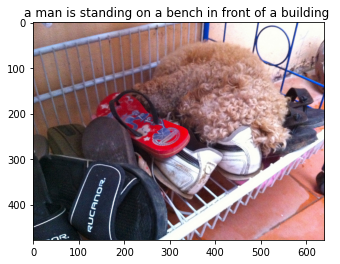

In [147]:
cap = predict(transformed_img_test, caption_generator, cnn_backbone)
plt.imshow(np.array(img_test))
plt.title(cap)
plt.show()